## Objective

In the bustling realm of the food industry, the ability to anticipate sales trends is not merely advantageous but crucial. This document is meticulously devised to predict pizza sales, serving as a pivotal guide for pizzerias striving to enhance various operational aspects, from inventory management to marketing strategies.

## Problem Statement

Predicting the exact number of pizzas a pizzeria will sell on a specific day presents a multifaceted challenge. A myriad of variables, including weekdays, special holidays, unforeseen weather changes, and promotional events, can substantially impact sales. A precise prediction model can revolutionize operations, facilitating efficient inventory management, waste minimization, optimal staffing, and, ultimately, profit maximization.

## Solution Blueprint
### 1. Data Collection

Historical Sales Data: Acquire comprehensive sales records, encapsulating daily sales figures over a prolonged period.
External Factors: Integrate data concerning local events, holidays, and meteorological conditions, as these can significantly influence sales.
### 2. Data Exploration

Sales Trends: Employ visualization tools, such as ggplot2, to discern recurring sales patterns and identify any noticeable spikes during local events or holidays.

External Influences: Investigate the impact of external factors, like weather conditions (rain, snow, heatwaves), on sales, considering aspects like how cold weather might amplify delivery requests.

### 3. Feature Engineering

Data Transformation: Transmute categorical data, such as weekdays or months, into numerical formats apt for modeling using functions like as.factor().

New Features: Innovate and introduce features like 'IsWeekend' or 'IsPromotionDay' to provide the model with clear flags for potentially influential days.

### 4. Model Selection and Hyperparameter Tuning

Model Selection: Employ various models, such as Linear Regression, Random Forest, and Gradient Boosting, to identify the most effective one for predicting pizza sales.

Hyperparameter Tuning: Utilize tools like GridSearchCV and RandomizedSearchCV from sklearn for tuning the models, ensuring optimal performance.

### 5. Feature Importance Analysis

Importance Metrics: Post-model selection, evaluate and visualize the significance of different features in predicting sales, aiding in understanding which variables most influence the predictions.

Informed Decision Making: Utilize the insights from feature importance to make data-driven decisions on aspects like marketing strategies and inventory management.

### 6. Model Evaluation

Validation: Ensure the selected model is validated using a separate dataset to ascertain its predictive accuracy and reliability.

Performance Metrics: Utilize metrics like Mean Squared Error (MSE) to evaluate the model’s performance, ensuring it is capable of making accurate predictions.

### 7. Implementation

Deployment: Implement the finalized model into the operational workflow of the pizzeria, enabling real-time sales predictions.
Continuous Improvement: Regularly assess the model’s performance and update it as needed to accommodate changes in sales trends and external factors.



In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

Data Exploration


Data exploration is a detective's investigation into the world of our data. I start by loading the historical sales data along with external factors like weather conditions. This is followed by a meticulous examination of the data, where we look for patterns, anomalies, correlations, and trends that could influence pizza sales.

Visualization plays a key role here; it allows us to see beyond the raw numbers and grasp the story they tell. For instance, I might create time series plots to observe sales over time, or scatter plots to understand the relationship between temperature and pizza orders. This visual approach helps us to quickly identify days with unusually high or low sales, which could indicate special events or promotions that we need to account for in our model.

The insights gained from this exploration inform our subsequent steps in feature engineering and model selection. By thoroughly understanding our data, I lay a solid foundation for building a predictive model that is not only accurate but also interpretable.



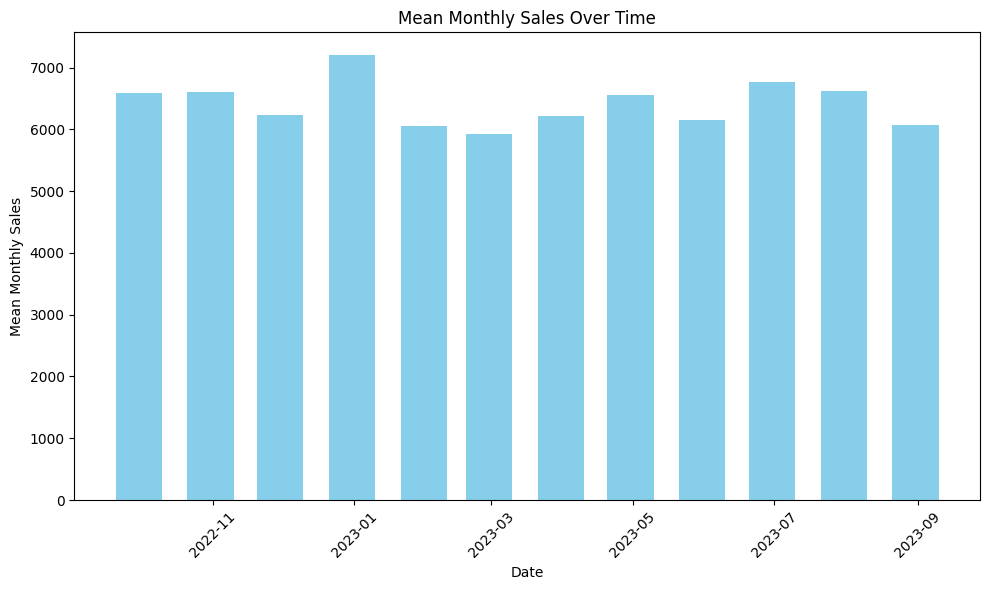

In [2]:
#2. Data Exploration
#2.1 Sales Trends



# Load the sales data and weather data from CSV files
sales_data = pd.read_csv('sales_data.csv', encoding='utf-8', skiprows=1)  # Skipping the 'Totals' row
sales_data.columns = ['Date', 'Total Orders', 'Booze Commission', 'Food Sales', 'Total Sales']


weather_data = pd.read_csv('weather_data.csv', delimiter=';', encoding='utf-8', skiprows=6)  # Skipping the metadata rows
weather_data['Date'] = weather_data['Local time in Christchurch (airport)'].str.split(' ').str[0]


# Merge the datasets again
merged_data = pd.merge(sales_data, weather_data, left_on='Date', right_on='Local time in Christchurch (airport)', how='left')
merged_data_clean = merged_data.dropna(subset=['T'])
# Determine the year based on the month
def assign_year(date_str):
    month_str = date_str.split(' ')[2]
    if month_str in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']:
        return date_str + ' 2023'
    else:
        return date_str + ' 2022'

merged_data['Date_x'] = merged_data['Date_x'].apply(assign_year)

# Convert to datetime with the correct format
merged_data['Date_x'] = pd.to_datetime(merged_data['Date_x'], format='%a %d %b %Y')


# Setting the Date as the index
merged_data.set_index('Date_x', inplace=True)

monthly_mean_sales = merged_data['Total Sales'].resample('M').mean()


# Plotting sales trends
plt.figure(figsize=(10, 6))
plt.bar(monthly_mean_sales.index, monthly_mean_sales.values, width=20, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Mean Monthly Sales')
plt.title('Mean Monthly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




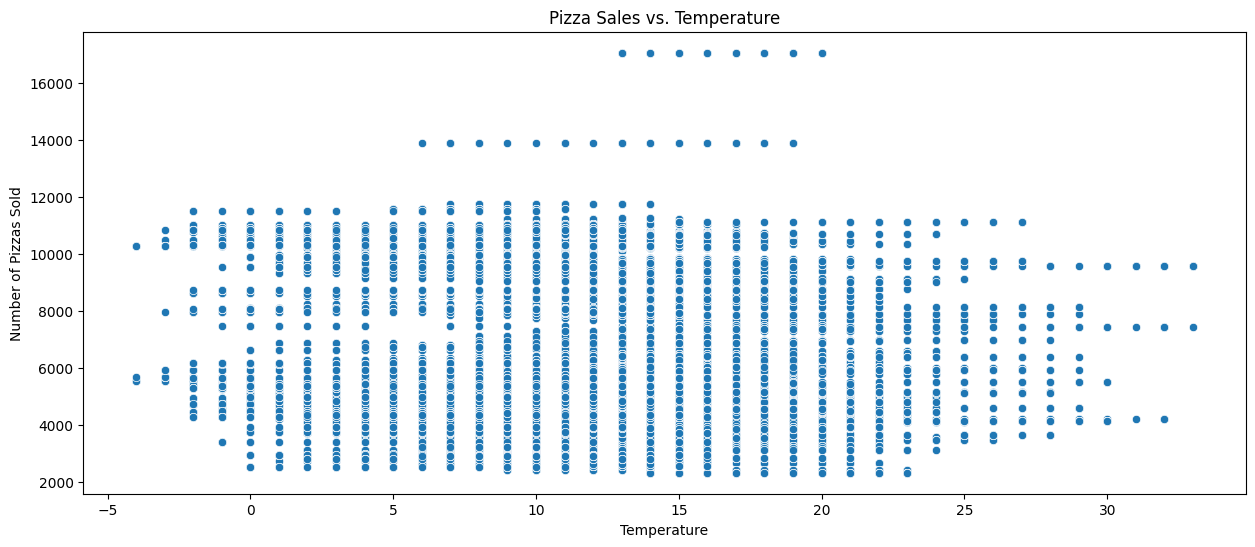

In [3]:

#2.2 External Influences
# Convert 'Date' in sales_data to a standard format
sales_data['Date'] = pd.to_datetime(sales_data['Date'], format='%a %d %b').dt.strftime('%d.%m')

# Convert 'Date' in weather_data to a standard format
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d.%m.%Y').dt.strftime('%d.%m')

# Merge the datasets again
merged_data = pd.merge(sales_data, weather_data, on='Date', how='left')

# Drop rows with missing temperature data for visualization
merged_data_clean = merged_data.dropna(subset=['T'])

# Plotting sales vs. temperature
plt.figure(figsize=(15, 6))
sns.scatterplot(data=merged_data_clean, x='T', y='Total Sales')
plt.title('Pizza Sales vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Number of Pizzas Sold')
plt.show()


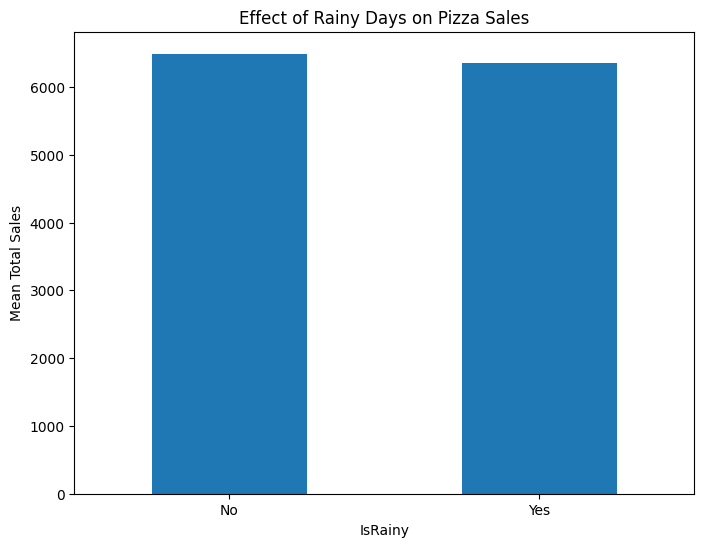

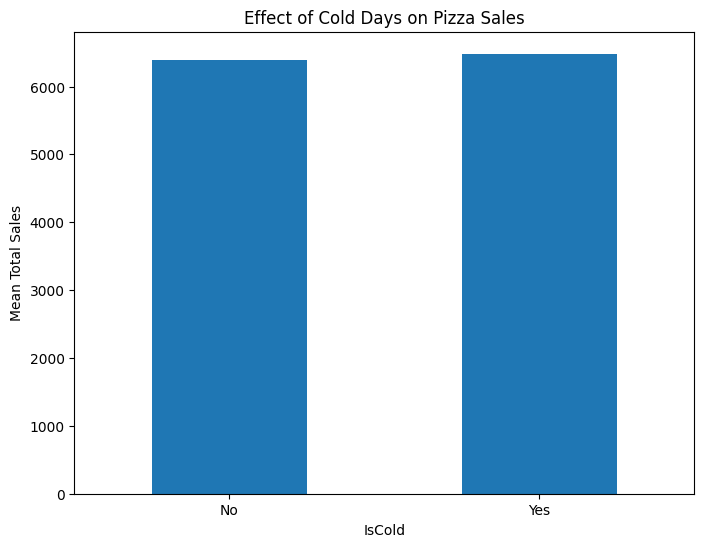

In [4]:


# 1. Handling Rainy Days
merged_data['IsRainy'] = merged_data['WW'].apply(lambda x: 1 if 'rain' in str(x).lower() else 0)
merged_data['IsRainy'] = merged_data.groupby('Date')['IsRainy'].transform('max')

# 2. Handling Cold Days
merged_data['IsCold'] = merged_data.groupby('Date')['T'].transform('mean').apply(lambda x: 1 if x < 10 else 0)


# 3. Handling Missing Data
# Example: Forward-fill method
merged_data.fillna(method='ffill', inplace=True)

# Plotting
def plot_comparison(data, condition, title):
    means = data.groupby(condition)['Total Sales'].mean()
    means.plot(kind='bar', figsize=(8, 6))
    plt.title(title)
    plt.ylabel('Mean Total Sales')
    plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
    plt.show()

# Plots
plot_comparison(merged_data, 'IsRainy', 'Effect of Rainy Days on Pizza Sales')
plot_comparison(merged_data, 'IsCold', 'Effect of Cold Days on Pizza Sales')


Feature Engineering


Feature engineering is about creating new variables from existing data that can provide additional predictive signals to our models. In this chunk, I handle various data types, such as categorical and numerical data, and apply domain knowledge to engineer relevant features for predicting pizza sales.

For instance, I may create a feature 'IsWeekend' to capture the pattern of increased sales on weekends. Similarly, 'IsPromotionDay' could be a flag indicating whether there was a special promotion or discount offered on that day, which typically drives higher sales volumes. I also perform normalization of data to ensure that our model isn't biased by the scale of the features.

The process of feature engineering is iterative and exploratory in nature. I hypothesize which features might be relevant, create them, and then test their impact on the model's performance. This can involve a lot of trial and error, but it's essential for developing a nuanced understanding of the factors that drive pizza sales.

By the end of this chunk, I have a dataset that's not only clean and well-structured but also enriched with features that encapsulate the complexities of our prediction task.



In [5]:
#3. Feature Engineering
# 3.1 Data Transformation
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%d.%m')
merged_data['Weekday'] = merged_data['Date'].dt.dayofweek
merged_data['Month'] = merged_data['Date'].dt.month

# 3.2 New Features
merged_data['IsWeekend'] = merged_data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
merged_data['IsPromotionDay'] = merged_data['IsWeekend']

# 3.3 External Factors
merged_data['IsCold'] = merged_data['T'].apply(lambda x: 1 if x < 10 else 0)

# 3.4 Normalize Data
scaler = MinMaxScaler()
merged_data[['Total Sales', 'T']] = scaler.fit_transform(merged_data[['Total Sales', 'T']])




Model Selection and Hyperparameter Tuning

Model selection is a critical decision point in our predictive modeling journey. It's where I choose the algorithm that will learn from my data to make future predictions. In this chunk, I experiment with various models such as Linear Regression, Random Forest, and Gradient Boosting, each with its own strengths and suitability for different types of data.

Hyperparameter tuning is akin to fine-tuning an instrument before a concert; it's the process of adjusting the knobs and dials of our model to hit the right notes. I use techniques like GridSearchCV and RandomizedSearchCV to systematically explore a range of parameter combinations and identify the most effective settings.

The data is split into training, validation, and test sets to ensure that our model can be trained on one subset of the data and validated on another, which helps to prevent overfitting and ensures that our model can generalize well to new, unseen data.

By the end of this chunk, I aim to have a well-tuned model that strikes a balance between bias and variance, ready to be evaluated on its predictive accuracy.



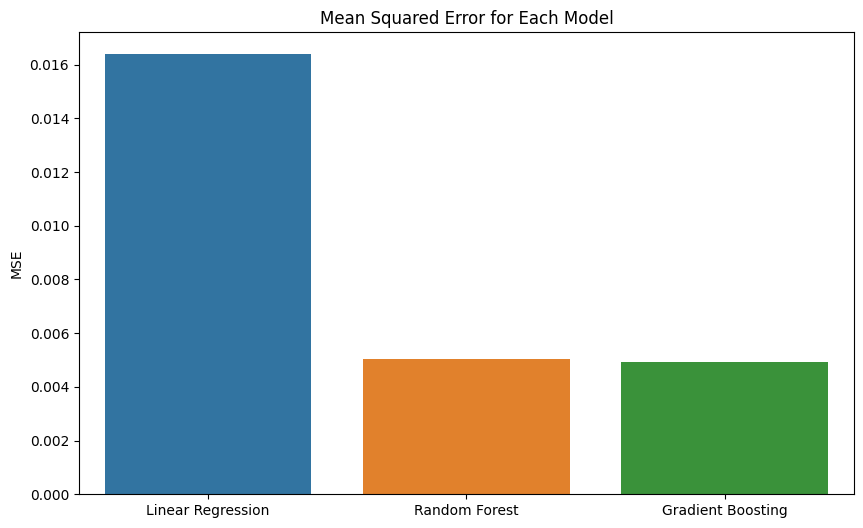

In [6]:
# 4. Model Selection & Hyperparameter Tuning


# Splitting the data into train, validation, and test sets
temp_df, test_df = train_test_split(merged_data, test_size=0.3, random_state=42)
train_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)


# Define features and target variable
features = ['T', 'Weekday', 'Month', 'IsWeekend', 'IsCold']
target = 'Total Sales'

X_train = train_df[features]
y_train = train_df[target]
X_valid = valid_df[features]
y_valid = valid_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_valid)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=10, random_state=42)
rf_search.fit(X_train, y_train)
rf_pred = rf_search.predict(X_valid)

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}
gb_search = GridSearchCV(gb, gb_params, cv=5)
gb_search.fit(X_train, y_train)
gb_pred = gb_search.predict(X_valid)

# Calculate MSE for each model
mse_lr = mean_squared_error(y_valid, lr_pred)
mse_rf = mean_squared_error(y_valid, rf_pred)
mse_gb = mean_squared_error(y_valid, gb_pred)

# Visualize the MSE
plt.figure(figsize=(10, 6))
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
mse_values = [mse_lr, mse_rf, mse_gb]
sns.barplot(x=models, y=mse_values)
plt.title('Mean Squared Error for Each Model')
plt.ylabel('MSE')
plt.show()





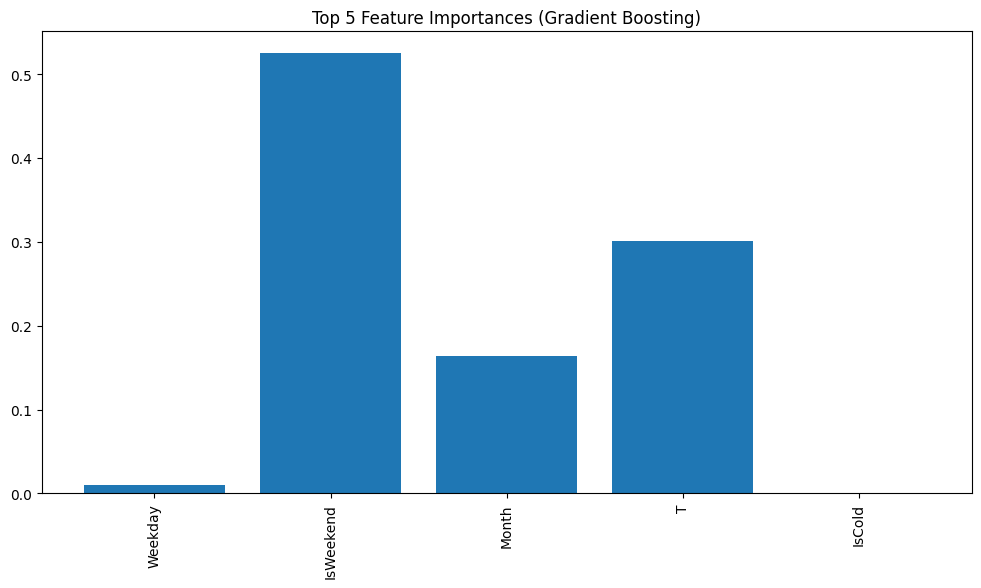

In [15]:
# Feature Importance for Gradient Boosting
gb.fit(X_valid, y_valid)
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

columns = ['Weekday', 'IsWeekend', 'Month', 'T', 'IsCold']

plt.figure(figsize=(12, 6))
plt.title("Top 5 Feature Importances (Gradient Boosting)")
plt.bar(range(5), importances, align="center")
plt.xticks(range(5), columns, rotation=90)
plt.show()




Model Evaluation

Model evaluation is the litmus test for my predictive models. It's where I critically assess how well my model is likely to perform in the real world. In this chunk, I employ various metrics to measure the accuracy and reliability of our models. The Mean Squared Error (MSE) is calculated to quantify the average squared difference between the predicted and actual sales figures, providing a clear picture of the model's prediction error.

I also visualize the MSE results to compare the performance across different models. This visual comparison is instrumental in identifying which model performs best and should be selected for deployment. Additionally, I delve into the feature importance analysis for models like Gradient Boosting to understand which features have the most significant impact on predictions.

The R^2 score is another metric I use, offering insight into the proportion of variance in the dependent variable that can be explained by the independent variables in the model. A higher R^2 score indicates a better fit of the model to the data.

By the end of this evaluation, I aim to have a clear understanding of our model's strengths and weaknesses, ensuring that we choose the best candidate for predicting pizza sales effectively.

Mean Squared Error: 0.00578376926300988
R^2 Score: 0.8010734404102594


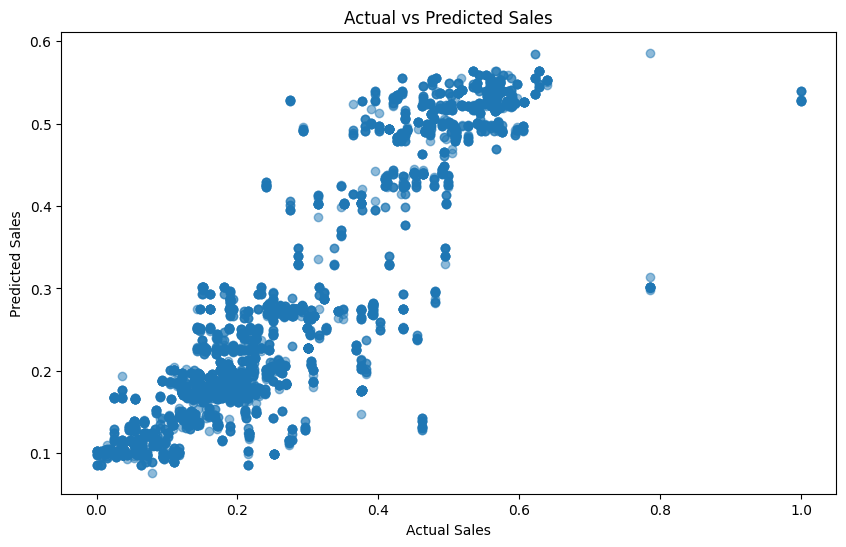

In [18]:
# Predicting the sales on the test set
predictions = gb.predict(X_test)

# Calculating and printing the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Calculating and printing the R^2 score
r2 = r2_score(y_test, predictions)
print(f"R^2 Score: {r2}")

# Plotting the actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()

The pursuit of a more refined model is never-ending. I plan to explore additional data sources that could enrich the model's input, such as more granular details on local events or social media sentiment analysis that could indicate a surge in pizza popularity.

I also intend to delve deeper into feature engineering, hypothesizing and testing new variables that may capture subtle nuances in sales patterns. Advanced techniques like feature selection algorithms and dimensionality reduction may reveal more influential predictors that I have not yet considered.

Another avenue for improvement is the exploration of more sophisticated models and ensemble methods that could capture complex relationships within the data more effectively. I am particularly interested in experimenting with neural networks and deep learning to see if they can provide a significant boost in predictive performance.

Moreover, I plan to implement a more robust cross-validation framework to ensure that the model's performance is consistent across different subsets of data. This will help in guarding against overfitting and ensuring that the model is as generalizable as possible.

Lastly, I aim to develop a user-friendly interface for the model, allowing non-technical stakeholders to make predictions and understand the factors driving those predictions. This will not only make the model more accessible but also foster a data-driven culture within the pizzeria.

In essence, my goal is to not only maintain the model's relevance over time but to also adapt and evolve the model as new data and techniques become available.

